# Final Classification Pipeline Creation & Evaluation

This notebook uses a logistic regression scikit-learn pipeline (based on the work in the previous notebook) to predict heart disease in a patient given a set of clinical measurements.

## Preparing the tools

We're going to use standard tools in the Data Scientist's toolbox.

In [42]:
# Import all the tools we need
# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression

# Model Evaluations from Scikit-Learn
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

# Other functions needed from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


The Google Cloud will require scikit-learn version 0.22.1. Let's double check that we have the right version.

In [9]:
import sklearn
print(f"sklearn version: {sklearn.__version__}")

sklearn version: 0.22.1


## Load Data

We'll load the tidy data set created in the data transformation notebook.

In [10]:
df = pd.read_csv("../data/02_df_tidy.csv")

## Prepare Data For Pipeline

In [11]:
# Split data into X and y
X = df.drop("target", axis = 1)
y = df["target"]

In [12]:
# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 123)

## Hyperparameter Tuning with GridSearchCV

Next, we'll try to improve the baseline `LogisticRegression` model using GridSearchCV. We'll also use the pipeline operator to string together a couple different pre-processing steps based on the data type. Again, most of this is coming directly from the previous notebook.

In [33]:
# Let's split up our features into three different groups that will undergo separate transformations:
cat_vars = ["cp","restecg","thal"]
num_vars = ["age", "trestbps", "chol", "thalach", "oldpeak", "slope","ca"]
bin_vars = ["sex", "fbs", "exang"]


cat_transformer = Pipeline(steps = [("impute", SimpleImputer(strategy = "most_frequent")),
                                    ("ohe", OneHotEncoder())])
                                   

num_transformer = Pipeline(steps = [("impute", SimpleImputer(strategy = "most_frequent")),
                                    ("scaler", PowerTransformer())]) # Here we are using a power-transform instead.

bin_transformer = Pipeline(steps = [("impute", SimpleImputer(strategy = "most_frequent"))])

preprocessor_pt = ColumnTransformer(transformers = [('cat', cat_transformer, cat_vars),
                                                  ('num', num_transformer, num_vars),
                                                  ('bin', bin_transformer, bin_vars)],
                                  remainder = "drop")

log_model_pipeline = Pipeline(steps = [
    ("preprocessing", preprocessor_pt),
    ("model", LogisticRegression())])

# Create a hyperparameter grid for Logistic Regression
np.random.seed(42)
param_grid = {"model__penalty": ["l2", "l1"],
                "model__C": np.logspace(-4, 4, 30), 
                "model__solver" : ["liblinear"]}


# Fit grid hyperparameter search model
gs_log_model = GridSearchCV(log_model_pipeline, param_grid, cv = 10)
gs_log_model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('impute',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                   

In [34]:
# Check the best hyperparameters
gs_log_model.best_params_

{'model__C': 0.7278953843983146,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

## Model Evaluation 

Now that the model constructed is what will likely be deployed to the Google Cloud, it's time to thoroughly evaluate its performance.

In [35]:
# Check best cross-validated score
print(f"Cross-Validated Training Score: {gs_log_model.best_score_}")

Cross-Validated Training Score: 0.8463333333333333


In [36]:
# Evaluate the grid search LogisticRegression model
print(f"Test Score: {gs_log_model.score(X_test, y_test)}")

Test Score: 0.7868852459016393


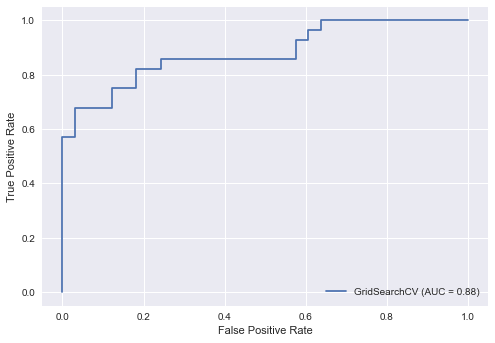

In [40]:
# Plot ROC curve and calculate AUC metric
plt.style.use("seaborn")

plot_roc_curve(gs_log_model, X_test, y_test);

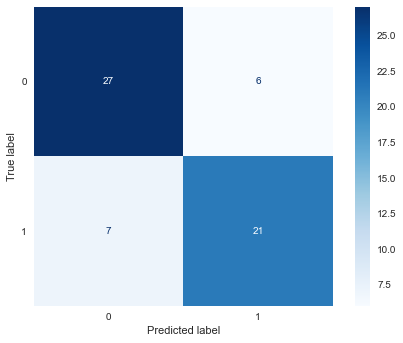

In [43]:
plot_confusion_matrix(gs_log_model, X_test, y_test, cmap = "Blues", values_format = ".3g")
plt.grid(False);

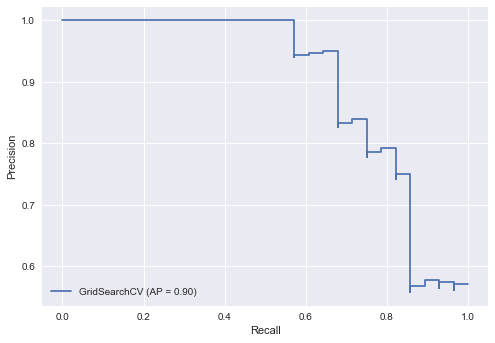

In [44]:
# Plot Precision Recall Curve
plot_precision_recall_curve(gs_log_model, X_test, y_test);

In [45]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        33
           1       0.78      0.75      0.76        28

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



## Export Model

In [46]:
import pickle

In [48]:
with open('../model/log_model_v1.pkl', 'wb') as model_file:
    pickle.dump(gs_log_model, model_file)